# Updates

After updating packages, restart the session and then start your notebook from imports.

# Imports

In [1]:
!pip install -U accelerate
!pip install -U transformers
!pip install -U umap
!pip install -U umap.umap_
!pip install -U colorama
!pip install -U umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 4.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
# import torch
# from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import spacy
import umap.umap_ as umap
import torch
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE, trustworthiness
from sklearn.decomposition import PCA , TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score , pairwise_distances_argmin_min
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
# from umap.umap_ import UMAP
# from umap-learn import UMAP
from keras.layers import Input, Dense
from keras.models import Model
from tabulate import tabulate
from colorama import Fore, Style
from sklearn.model_selection import GridSearchCV
from transformers import AutoModelForCausalLM, AutoTokenizer

## Reading Json Files

In [3]:
def jsonl_tolist(jsonl_file_path):
    records = []
    with open(jsonl_file_path, 'r') as f:
        for line in f:
            record = json.loads(line)
            records.append(record)
    return records


In [4]:
jsonl_files_path = {
    "train": "train_imdb.jsonl",
    "test": "test_imdb.jsonl",
    "unlabeled": "aug_imdb_unlabeled.jsonl"
}

In [5]:
df_train = pd.DataFrame(jsonl_tolist(jsonl_files_path["train"]))
df_test = pd.DataFrame(jsonl_tolist(jsonl_files_path["test"]))
df_unlabeled = pd.DataFrame(jsonl_tolist(jsonl_files_path["unlabeled"]))

In [7]:
df_train.to_csv("/content/CSVs/train.csv")
df_test.to_csv("/content/CSVs/test.csv")
df_unlabeled.to_csv("/content/CSVs/unlabeled.csv")

In [8]:
def get_feature_columns_name(df):
    features_columns = []
    for i in range(len(df["embedding"][0])):
        name = "feature" + f"{i + 1}"
        features_columns.append(name)
    return features_columns
feature_columns = get_feature_columns_name(df_train)

In [9]:
df_train[get_feature_columns_name(df_train)] = df_train["embedding"].apply(pd.Series)
df_test[get_feature_columns_name(df_test)] = df_test["embedding"].apply(pd.Series)
df_unlabeled[get_feature_columns_name(df_unlabeled)] = df_unlabeled["embedding"].apply(pd.Series)

<ipython-input-9-ae3a40e1e997>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[get_feature_columns_name(df_train)] = df_train["embedding"].apply(pd.Series)
<ipython-input-9-ae3a40e1e997>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[get_feature_columns_name(df_train)] = df_train["embedding"].apply(pd.Series)
<ipython-input-9-ae3a40e1e997>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

# EDA

In [10]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not",
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)


In [11]:
def to_lowercase(text):
    return text.lower()

In [12]:
def remove_digits(text):
    return re.sub("\w*\d\w*", "", text)

In [13]:
def remove_punctuation(text):
    return re.sub("[%s]" % re.escape(string.punctuation), "", text)

In [14]:
def remove_short_words(text):
        return " ".join(word for word in text.split() if len(word) >= 3 or word.lower() == "no")

In [15]:
def remove_extra_spaces(text):
    return re.sub(" +", " ", text)

In [16]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

negation_words = {"not", "no", "never", "none", "nobody", "nothing", "neither", "nowhere", "cannot"}

def lemmatize_and_remove_stop_words(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop or token.text.lower() in negation_words])

In [17]:
def calculate_polarity(text):
    return TextBlob(text).sentiment.polarity

In [18]:
def preprocess_dataframe(df):
    df = df.copy()
    df["text"] = df["text"].apply(expand_contractions)
    df["text"] = df["text"].apply(to_lowercase)
    df["text"] = df["text"].apply(remove_digits)
    df["text"] = df["text"].apply(remove_punctuation)
    df["text"] = df["text"].apply(remove_short_words)
    df["text"] = df["text"].apply(remove_extra_spaces)
    df["text"] = df["text"].apply(lemmatize_and_remove_stop_words)
    df["polarity"] = df["text"].apply(calculate_polarity)
    return df

In [19]:
df_train = preprocess_dataframe(df_train)
df_test = preprocess_dataframe(df_test)
df_unlabeled = preprocess_dataframe(df_unlabeled)

## Understanding the common words used in the texts

In [20]:
def plot_common_ngrams(all_text, n=2, bg_color="white"):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngram_matrix = vectorizer.fit_transform([all_text])
    ngram_names = vectorizer.get_feature_names_out()
    ngram_counts = ngram_matrix.sum(axis=0)
    ngram_dict = {ngram: count for ngram, count in zip(ngram_names, ngram_counts.tolist()[0])}
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,background_color=bg_color).generate_from_frequencies(ngram_dict)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Common {n}-grams")
    plt.show()

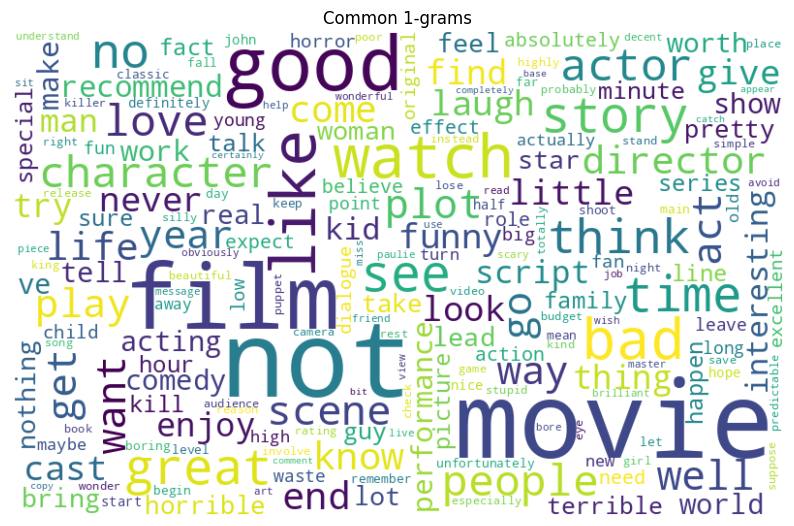

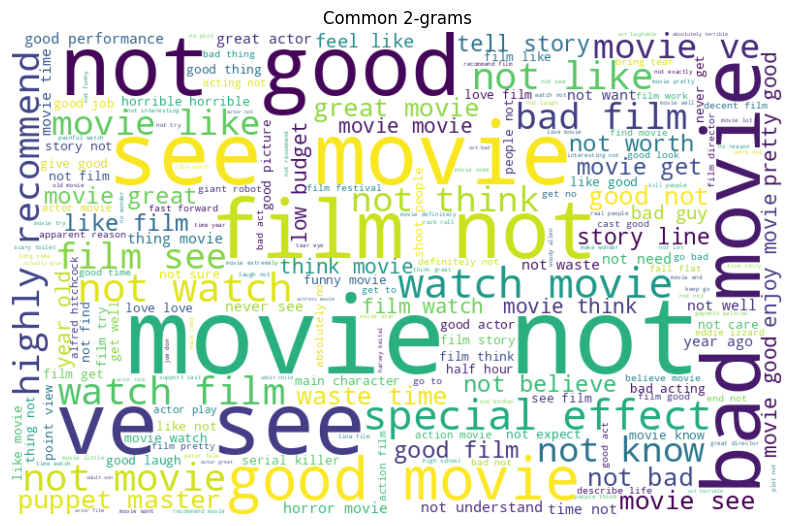

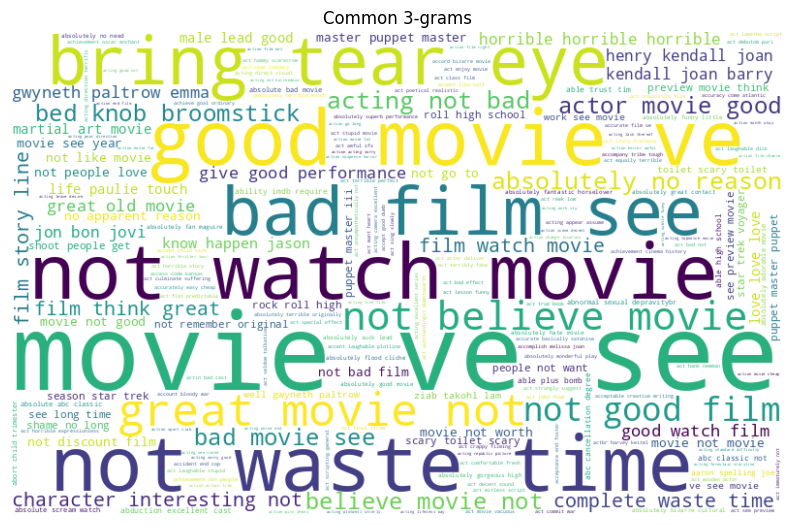

In [21]:
combi = pd.concat([df_train, df_test], ignore_index=True)
all_words = " ".join([text for text in combi["text"]])
plot_common_ngrams(all_words, n=1)
plot_common_ngrams(all_words, n=2)
plot_common_ngrams(all_words, n=3)

### Words in positive texts

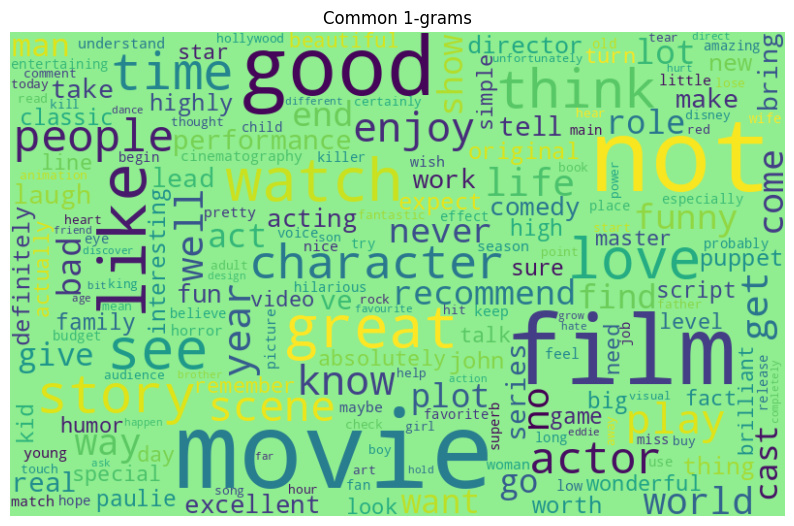

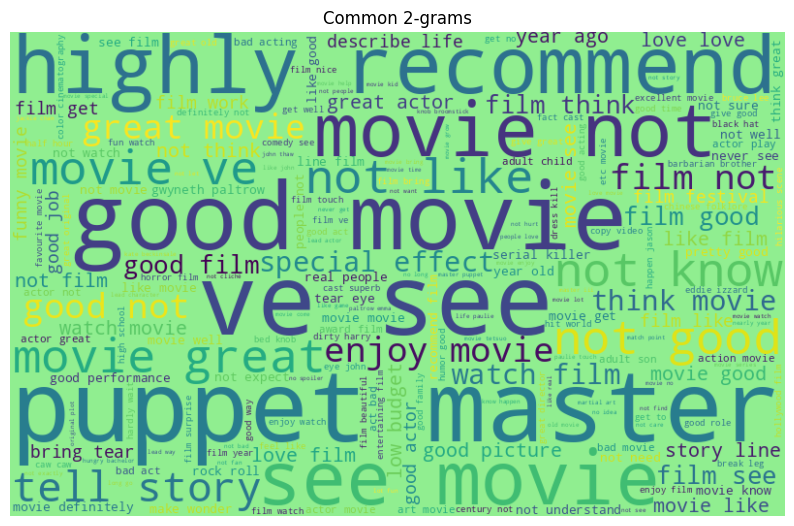

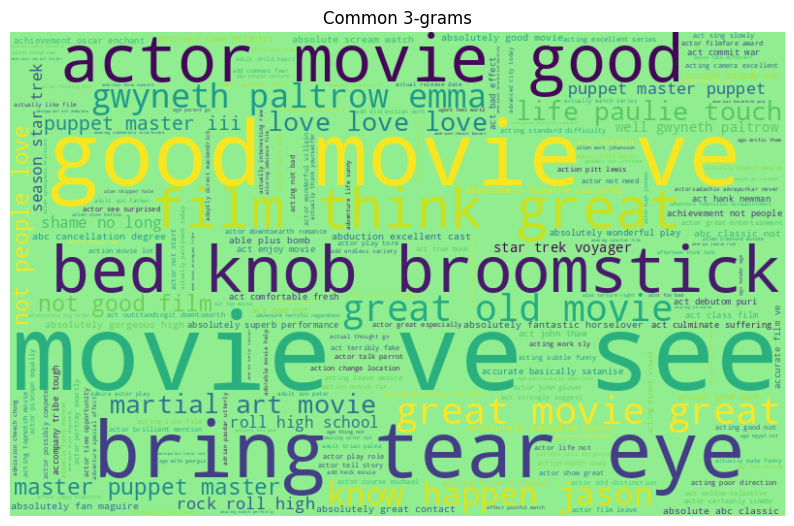

In [22]:
positive_words = " ".join([text for text in combi["text"][combi["label"] == 1]])
plot_common_ngrams(positive_words, n=1, bg_color="#90EE90")
plot_common_ngrams(positive_words, n=2, bg_color="#90EE90")
plot_common_ngrams(positive_words, n=3, bg_color="#90EE90")

### Words in negative texts

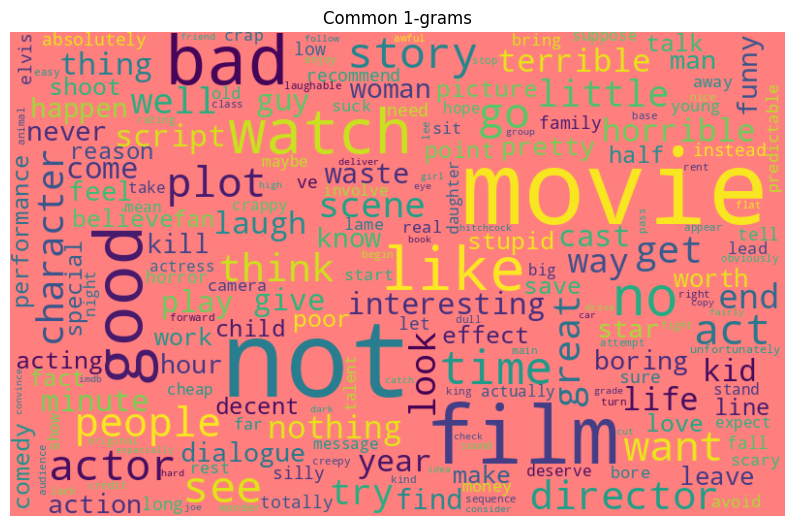

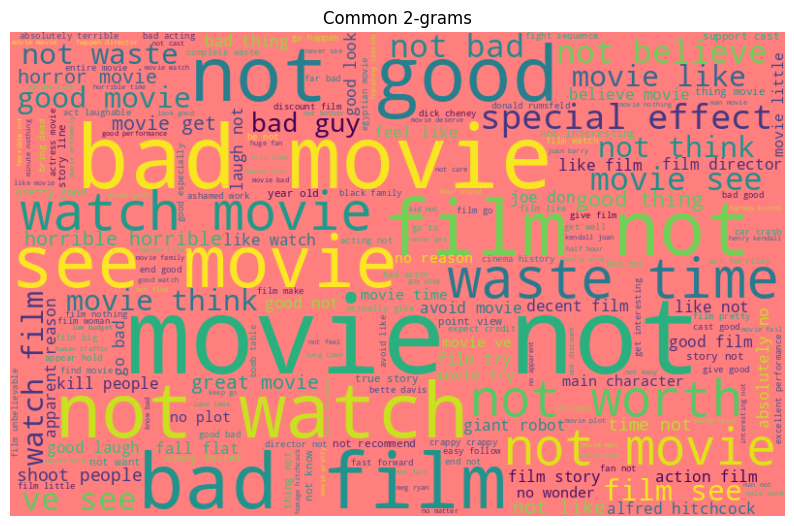

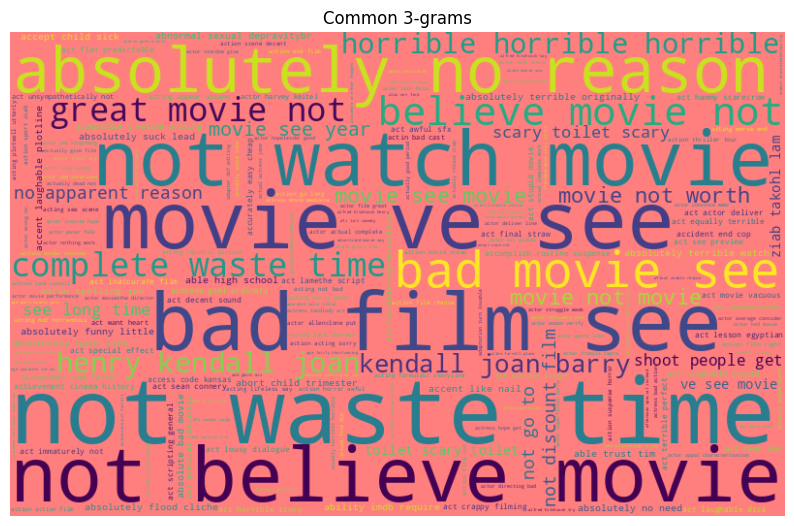

In [23]:
negation_words = " ".join([text for text in combi["text"][combi["label"] == 0]])
plot_common_ngrams(negation_words, n=1, bg_color="#FF7F7F")
plot_common_ngrams(negation_words, n=2, bg_color="#FF7F7F")
plot_common_ngrams(negation_words, n=3, bg_color="#FF7F7F")

## Sentence Lenght and Polarity analysis

In [24]:
df_train["text_word_count"] = df_train["text"].apply(lambda x: len(str(x).split()))
df_test["text_word_count"] = df_test["text"].apply(lambda x: len(str(x).split()))

In [25]:
def plot_distribution(df, target, title, bins):
    positive_df = df[df["label"] == 1]
    negative_df = df[df["label"] == 0]

    plt.figure(figsize=(10, 6))
    sns.histplot(data=positive_df, x=target, bins=bins, kde=False, color="green", label="Positive")
    sns.histplot(data=negative_df, x=target, bins=bins, kde=False, color="red", label="Negative")
    plt.xlabel("Text Length")
    plt.ylabel("Count")
    plt.title(f'{title} Distribution (Positive vs. Negative)')
    plt.legend()
    plt.show()


### For train dataset

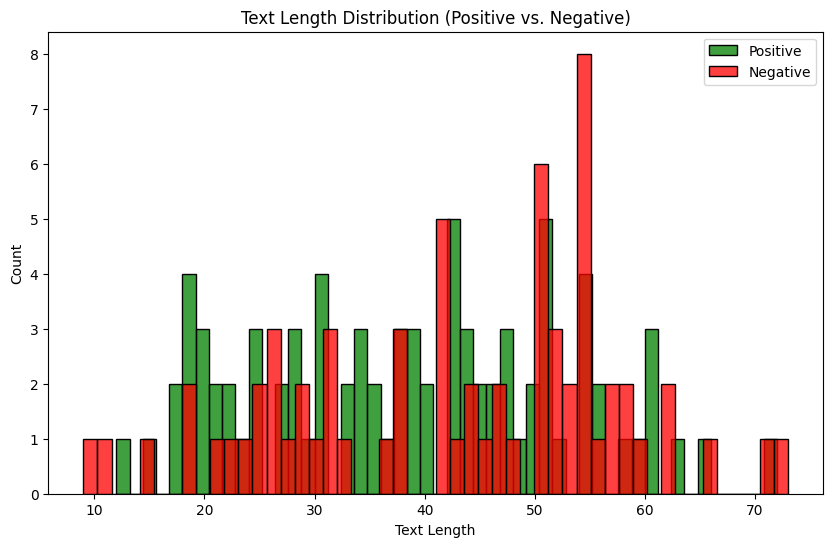

In [26]:
plot_distribution(df_train, "text_word_count", "Text Length", 50)


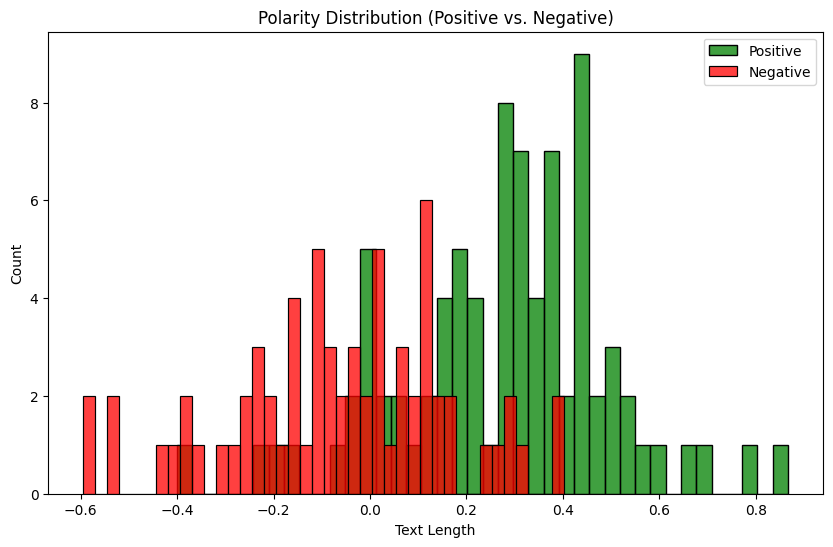

In [27]:
plot_distribution(df_train, "polarity", "Polarity", 40)

### For Test dataset

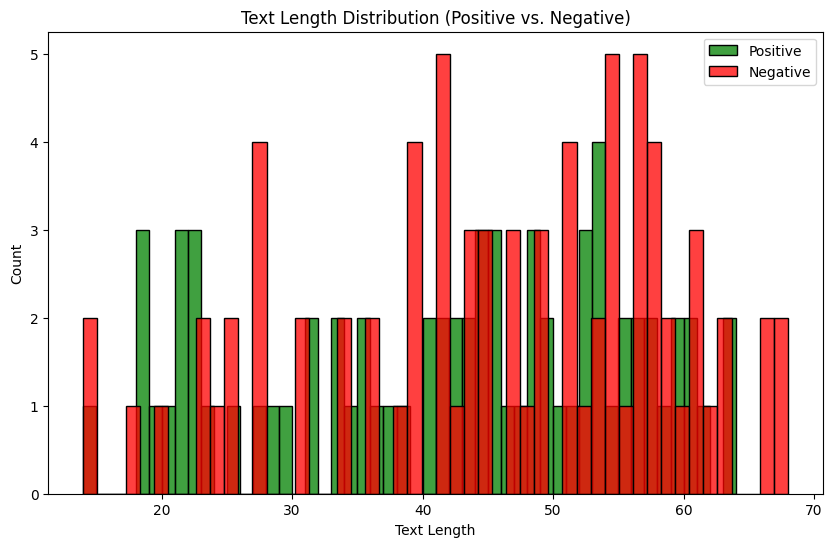

In [28]:
plot_distribution(df_test, "text_word_count", "Text Length", 50)

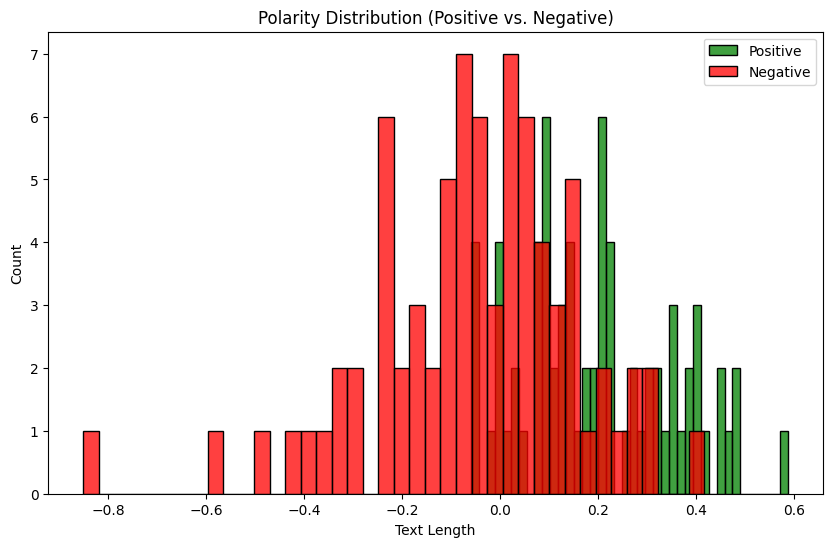

In [29]:
plot_distribution(df_test , 'polarity', "Polarity", 40)

In [30]:
def plot_boxplots(df, columns, tytle):
    for column in columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=df[column])
        plt.title(f'{tytle} Box plot of {column}')
        plt.show()


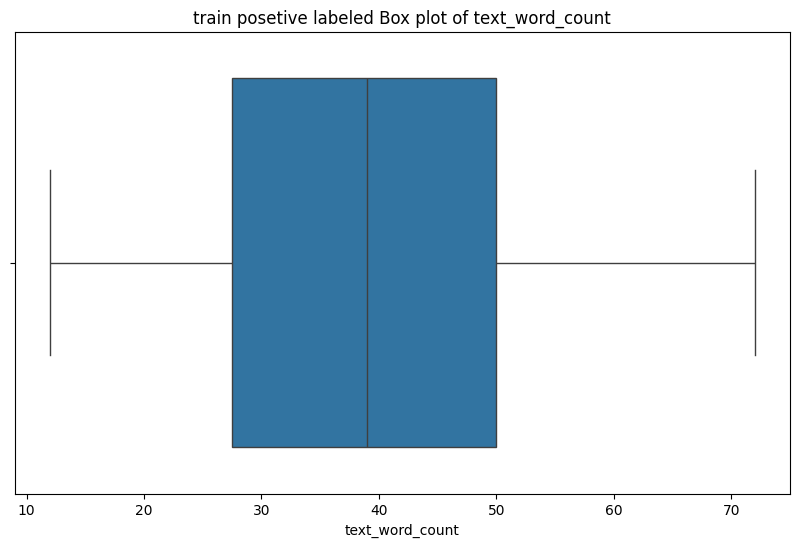

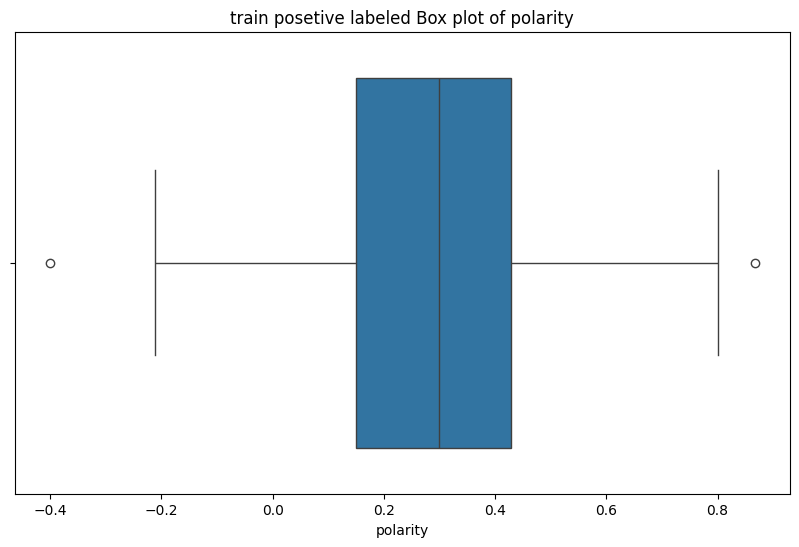

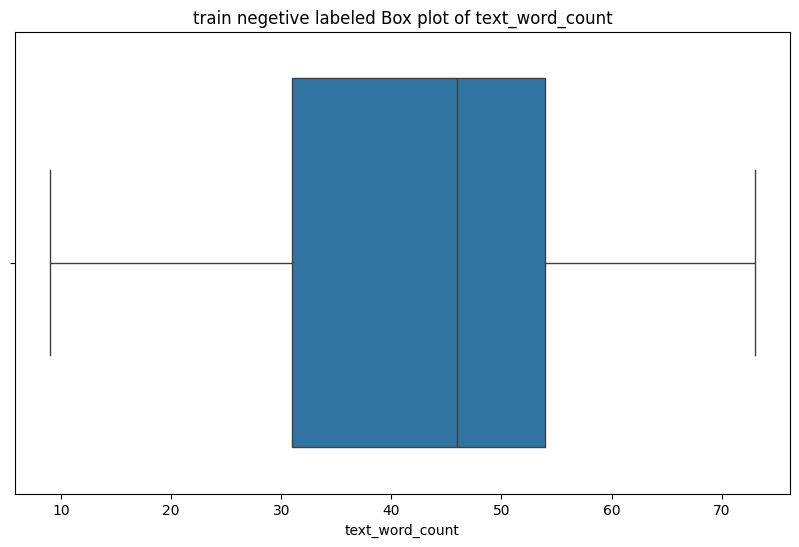

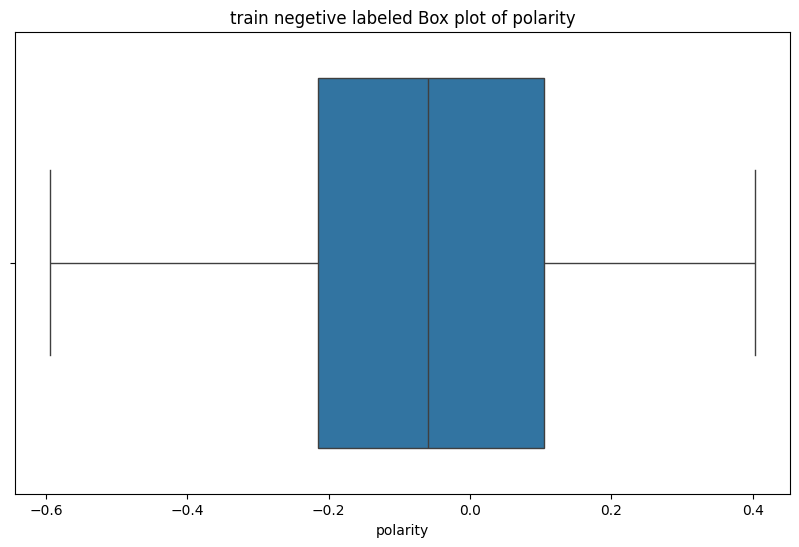

In [31]:
plot_boxplots(df_train[df_train['label'] == 1], ['text_word_count', 'polarity'], "train posetive labeled")
plot_boxplots(df_train[df_train['label'] == 0], ['text_word_count', 'polarity'], "train negetive labeled")

In [32]:
def plot_most_frequent_ngrams(text, n, ngram, title, color):
    vectorizer = CountVectorizer(ngram_range=(ngram, ngram))

    X = vectorizer.fit_transform([text])

    ngrams_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    ngram_counts = ngrams_df.sum(axis=0)

    top_ngrams = ngram_counts.nlargest(n)

    plt.figure(figsize=(10, 6))
    plt.barh(top_ngrams.index, top_ngrams.values, color=color)
    plt.title(f'{title} Top {n} Most Frequent {ngram}-grams')
    plt.xlabel('Frequency')
    plt.ylabel(f'{ngram}-grams')
    plt.gca().invert_yaxis()
    plt.show()

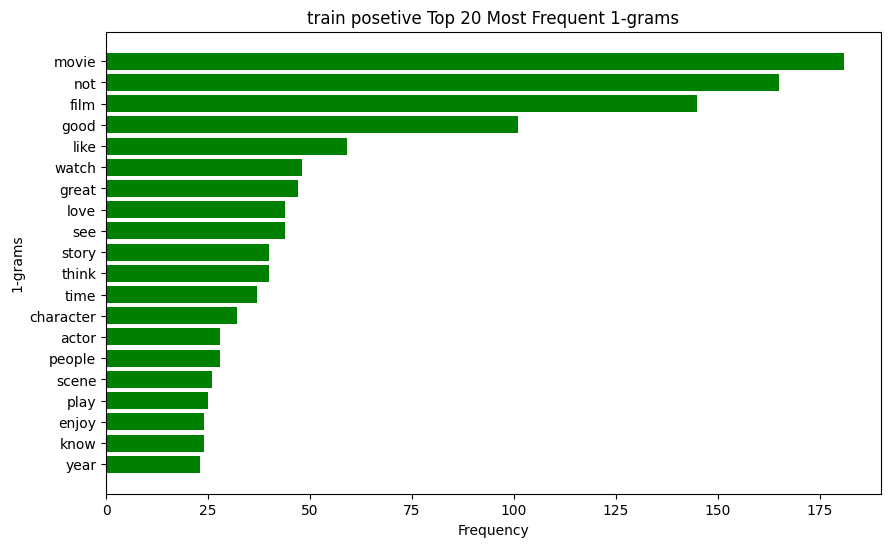

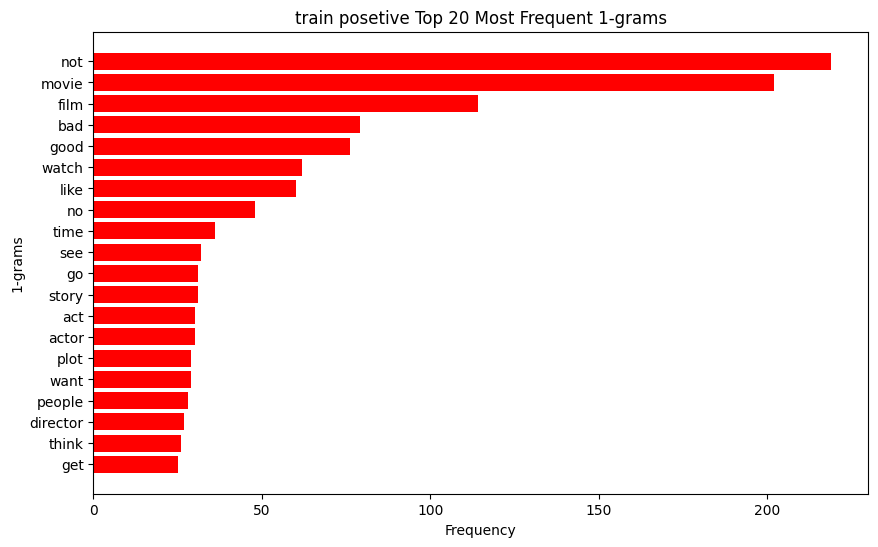

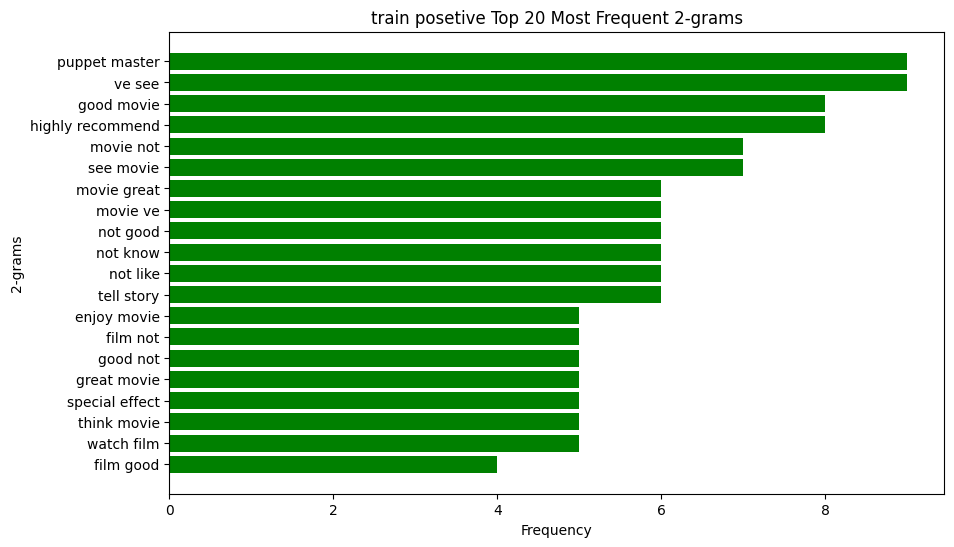

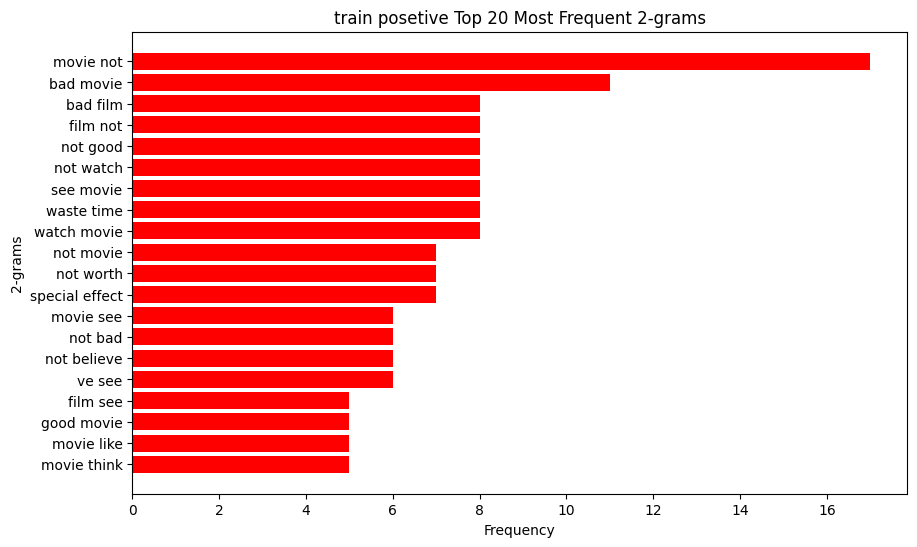

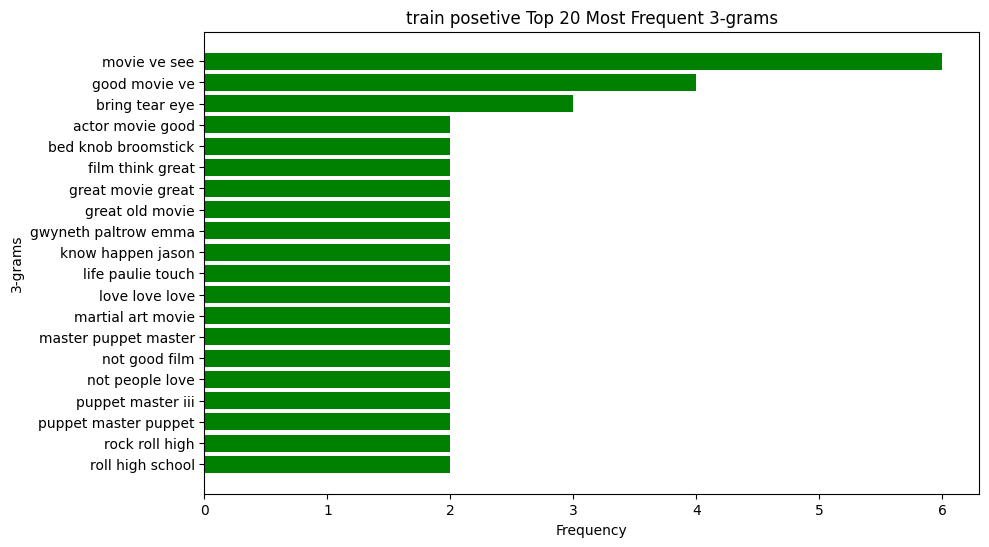

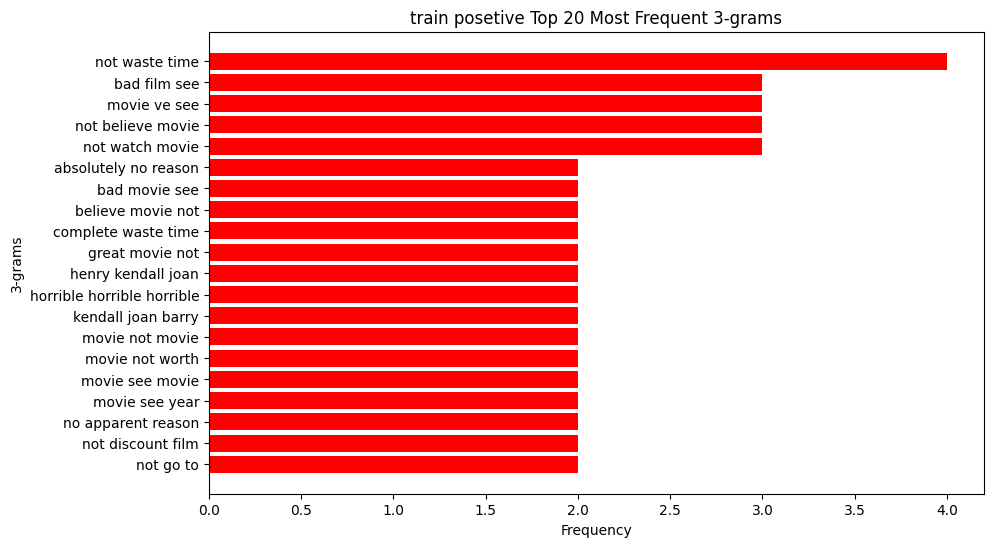

In [33]:
plot_most_frequent_ngrams(positive_words, 20, 1, 'train posetive', 'green')
plot_most_frequent_ngrams(negation_words, 20, 1, 'train posetive', 'red')
plot_most_frequent_ngrams(positive_words, 20, 2, 'train posetive', 'green')
plot_most_frequent_ngrams(negation_words, 20, 2, 'train posetive', 'red')
plot_most_frequent_ngrams(positive_words, 20, 3, 'train posetive', 'green')
plot_most_frequent_ngrams(negation_words, 20, 3, 'train posetive', 'red')

## Density Reduction

`Density reduction` for feature embedding is a set of techniques used to reduce the number of variables or features in a dataset while retaining as much of the important information as possible. This process is particularly useful in machine learning and data analysis for improving model performance, reducing computational cost, and enhancing data visualization. Here are explanations of some common methods:
     
1. **t-SNE (t-Distributed Stochastic Neighbor Embedding):**    
       
    `t-SNE` is a nonlinear dimensionality reduction technique primarily used for data visualization. It reduces high-dimensional data to two or three dimensions, making it easier to visualize complex patterns and relationships.
2. **PCA (Principal Component Analysis):**    
        
    `PCA` is a linear dimensionality reduction technique that transforms the original features into a new set of orthogonal features called principal components. These components are ordered by the amount of variance they capture from the data.
3. **UMAP (Uniform Manifold Approximation and Projection):**
      
    `UMAP` is a nonlinear dimensionality reduction technique that is particularly good at preserving both local and global data structure. It is based on manifold learning and topological data analysis
4. **Autoencoder:**      
       
    An `autoencoder` is a type of artificial neural network used for unsupervised learning of efficient codings of data. It consists of an encoder that compresses the data into a lower-dimensional latent space and a decoder that reconstructs the data from this latent space.
5. **TruncatedSVD (Truncated Singular Value Decomposition):**  
           
    `TruncatedSVD` is a linear dimensionality reduction technique similar to PCA but is particularly effective for sparse matrices, often used in Natural Language Processing (NLP) for Latent Semantic Analysis (LSA).
        

- `t-SNE` and `UMAP` are excellent for visualizing high-dimensional data and revealing clusters, but they can be computationally expensive and sensitive to parameters.
- `PCA` and `TruncatedSVD` are linear techniques that are computationally efficient and suitable for large datasets, particularly when the relationships in the data are mostly linear.
- `Autoencoders` are versatile and powerful for capturing complex patterns in data but require significant computational resources and data for training.              

In [34]:
def visualize_and_reduce_embeddings(df, feature_columns, method="tsne", n_components=2):
    df_copy = df.copy()
    df_label_0 = df[df["label"] == 0]
    df_label_1 = df[df["label"] == 1]

    if method == "tsne":
        reducer = TSNE(n_components=n_components, random_state=42)
    elif method == "pca":
        reducer = PCA(n_components=n_components, random_state=42)
    elif method == "umap":
        reducer = umap.UMAP(n_components=n_components, random_state=42)
    elif method == "truncated_svd":
        reducer = TruncatedSVD(n_components=n_components, random_state=42)
    else:
        raise ValueError("Invalid method specified.")

    embeddings_0 = reducer.fit_transform(df_label_0[feature_columns])
    embeddings_1 = reducer.fit_transform(df_label_1[feature_columns])

    for i in range(n_components):
        df_copy.loc[df["label"] == 0, f"{method.upper()}_{i+1}"] = embeddings_0[:, i]
        df_copy.loc[df["label"] == 1, f"{method.upper()}_{i+1}"] = embeddings_1[:, i]

    if n_components > 2:
        print(f"Note: Only the first two components will be visualized for {method.upper()}.")
    plt.scatter(embeddings_0[:, 0], embeddings_0[:, 1], c="red", label="Label 0")
    plt.scatter(embeddings_1[:, 0], embeddings_1[:, 1], c="green", label="Label 1")

    plt.legend()
    plt.xlabel(f"{method.upper()} Dimension 1")
    plt.ylabel(f"{method.upper()} Dimension 2")
    plt.title(f"Visualization of Embeddings using {method.upper()}")

    plt.tight_layout()
    plt.show()

    columns_to_drop = feature_columns + ["text", "embedding", "text_word_count"]
    df_copy.drop(columns=columns_to_drop, axis=1, inplace=True)

    return df_copy, reducer

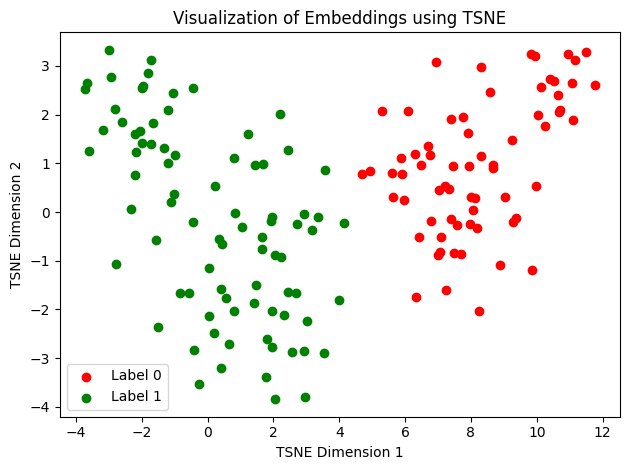

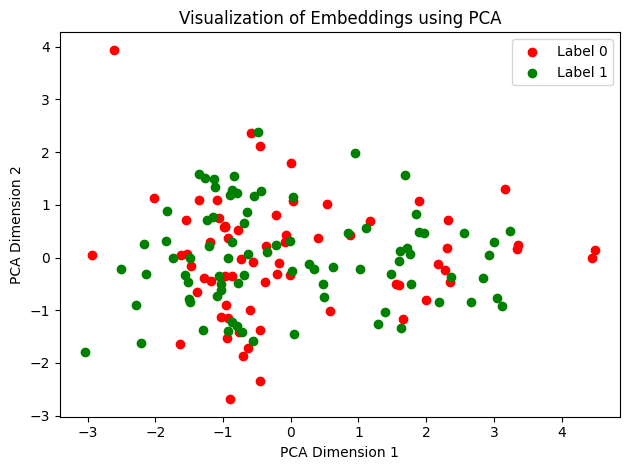

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


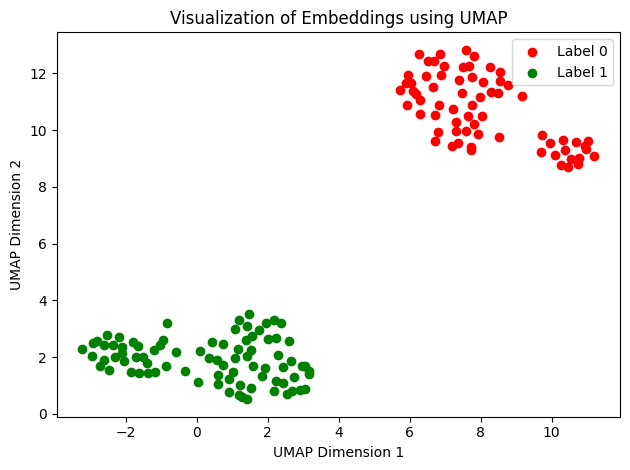

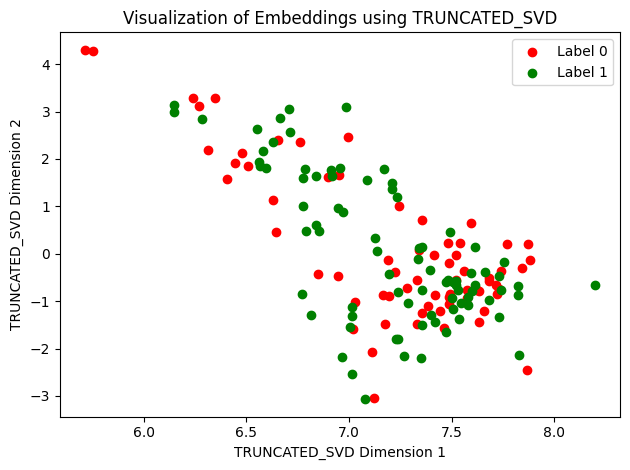

In [35]:
df_train_tsne, tsne_reducer = visualize_and_reduce_embeddings(df_train, feature_columns, method='tsne')
df_train_pca, pca_reducer = visualize_and_reduce_embeddings(df_train, feature_columns, method='pca')
df_train_umap, umap_reducer = visualize_and_reduce_embeddings(df_train, feature_columns, method='umap')
df_train_truncated_svd, truncated_svd_reducer = visualize_and_reduce_embeddings(df_train, feature_columns, method='truncated_svd')

In [36]:
def visualize_autoencoder_by_label(df, feature_columns, encoding_dim=2):
    input_img = Input(shape=(len(feature_columns),))
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    decoded = Dense(len(feature_columns), activation='sigmoid')(encoded)
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    df_label_0 = df[df['label'] == 0]
    df_label_1 = df[df['label'] == 1]
    autoencoder.fit(df_label_0[feature_columns], df_label_0[feature_columns],
                    epochs=50,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(df_label_1[feature_columns], df_label_1[feature_columns]))
    embeddings_autoencoder_0 = encoder.predict(df_label_0[feature_columns])
    embeddings_autoencoder_1 = encoder.predict(df_label_1[feature_columns])

    plt.scatter(embeddings_autoencoder_0[:, 0], embeddings_autoencoder_0[:, 1], c='red', label='Label 0')
    plt.scatter(embeddings_autoencoder_1[:, 0], embeddings_autoencoder_1[:, 1], c='green', label='Label 1')
    plt.legend()
    plt.xlabel('Autoencoder Dimension 1')
    plt.ylabel('Autoencoder Dimension 2')
    plt.tight_layout()
    plt.show()
    return encoder

Epoch 1/50
1/1 [==============================] - 1s 905ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 2/50
1/1 [==============================] - 0s 39ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 3/50
1/1 [==============================] - 0s 44ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 4/50
1/1 [==============================] - 0s 37ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 5/50
1/1 [==============================] - 0s 37ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 6/50
1/1 [==============================] - 0s 40ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 7/50
1/1 [==============================] - 0s 40ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 8/50
1/1 [==============================] - 0s 50ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 9/50
1/1 [==============================] - 0s 40ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 10/50
1/1 [==============================] - 0s 41ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 11/50
1/1 [===========

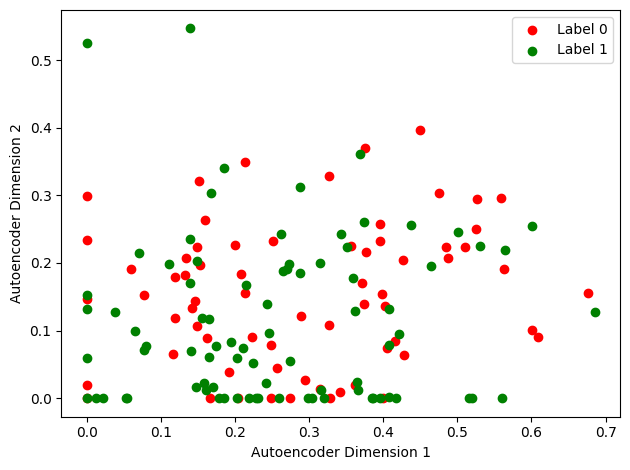

In [37]:
encoder = visualize_autoencoder_by_label(df_train, get_feature_columns_name(df_train))

`Trustworthiness`, in the context of dimensionality reduction techniques, refers to the reliability of the low-dimensional embeddings in preserving the local structure of the original high-dimensional data. It measures how faithfully the neighboring points in the high-dimensional space are preserved in the low-dimensional representation.

In [38]:
def compute_trustworthiness(df_label_0, df_label_1, feature_columns, method="tsne", n_components=2):
    if method == "tsne":
        reducer = TSNE(n_components=n_components,random_state=42)
    elif method == "pca":
        reducer = PCA(n_components=n_components,random_state=42)
    elif method == "umap":
        reducer = umap.UMAP(n_components=n_components,random_state=42)
    elif method == "truncated_svd":
        reducer = TruncatedSVD(n_components=n_components,random_state=42)
    else:
        raise ValueError("Invalid method specified.")

    embeddings_0 = reducer.fit_transform(df_label_0[feature_columns])
    embeddings_1 = reducer.fit_transform(df_label_1[feature_columns])

    trust_0 = trustworthiness(df_label_0[feature_columns], embeddings_0)
    trust_1 = trustworthiness(df_label_1[feature_columns], embeddings_1)

    print(f"Trustworthiness for {method.upper()} Label 0: {trust_0}")
    print(f"Trustworthiness for {method.upper()} Label 1: {trust_1}")

    return reducer

def compute_trustworthiness_for_each_model(df_label_0, df_label_1, feature_columns, methods=['tsne', 'pca', 'umap', 'truncated_svd'], n_components=2):
    for method in methods:
        compute_trustworthiness(df_label_0, df_label_1, feature_columns, method=method, n_components=n_components)
        print('\n')

In [39]:
df_label_0 = df_train[df_train["label"] == 0]
df_label_1 = df_train[df_train["label"] == 1]
feature_columns = get_feature_columns_name(df_train)
compute_trustworthiness_for_each_model(df_label_0, df_label_1, feature_columns)

Trustworthiness for TSNE Label 0: 0.8961295218821148
Trustworthiness for TSNE Label 1: 0.8869076305220883


Trustworthiness for PCA Label 0: 0.8327852264103213
Trustworthiness for PCA Label 1: 0.7968192771084337




/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Trustworthiness for UMAP Label 0: 0.8430053124209461
Trustworthiness for UMAP Label 1: 0.8521124497991968


Trustworthiness for TRUNCATED_SVD Label 0: 0.7759170250442702
Trustworthiness for TRUNCATED_SVD Label 1: 0.7781204819277108




# Semi-Supervised

## Label Propagation

In [40]:
def train_and_evaluate_classifiers(X_train, y_train, X_test, y_test):
    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Support Vector Machine": SVC(probability=True, random_state=42)
    }

    scores_list = []
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
        scores_list.append([name, accuracy, precision, recall, f1, roc_auc])

    headers = ["Classifier", "Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC"]
    colored_headers = [Fore.GREEN + header + Fore.RESET for header in headers]
    def format_score(score):
        if isinstance(score, float):
            return Fore.YELLOW + "{:.6f}".format(score) + Fore.RESET
        else:
            return Fore.YELLOW + str(score) + Fore.RESET

    colored_scores_list = [[format_score(score) for score in row] for row in scores_list]
    print(Fore.CYAN + Style.BRIGHT + "Classifier Evaluation Scores" + Style.RESET_ALL)
    print(tabulate(colored_scores_list, headers=colored_headers, tablefmt="fancy_grid", numalign="center", stralign="center", missingval="-"))

In [41]:
df_train.head(1)

text  label  \
0  fairly good romantic comedy not think ve see m...      1   

                                           embedding  feature1  feature2  \
0  [-0.0167805497, -0.0395836979, 0.1233159453, -... -0.016781 -0.039584   

   feature3  feature4  feature5  feature6  feature7  ...  feature761  \
0  0.123316 -0.112681  0.147103  0.022566  0.053462  ...    0.035722   

   feature762  feature763  feature764  feature765  feature766  feature767  \
0   -0.379844   -0.180571   -0.036396     0.11442   -0.036291    0.421711   

   feature768  polarity  text_word_count  
0    0.060781  0.316942               39  

[1 rows x 773 columns]

In [42]:
droped_features = ['text', 'embedding', 'text_word_count']

In [43]:
labeled_train_df = df_train.copy()
labeled_train_df = labeled_train_df.drop(droped_features, axis=1)
labeled_train_df.head(1)

label  feature1  feature2  feature3  feature4  feature5  feature6  \
0      1 -0.016781 -0.039584  0.123316 -0.112681  0.147103  0.022566   

   feature7  feature8  feature9  ...  feature760  feature761  feature762  \
0  0.053462  0.613809  -0.01048  ...   -0.195328    0.035722   -0.379844   

   feature763  feature764  feature765  feature766  feature767  feature768  \
0   -0.180571   -0.036396     0.11442   -0.036291    0.421711    0.060781   

   polarity  
0  0.316942  

[1 rows x 770 columns]

In [44]:
df_unlabeled = df_unlabeled.drop(['text', 'embedding'] , axis=1)
df_unlabeled.head(1)

feature1  feature2  feature3  feature4  feature5  feature6  feature7  \
0 -0.097578 -0.153636  0.311417   0.03052  0.211818 -0.151885  0.006378   

   feature8  feature9  feature10  ...  feature760  feature761  feature762  \
0  0.366098  0.190314  -0.276206  ...   -0.182791   -0.053788   -0.231376   

   feature763  feature764  feature765  feature766  feature767  feature768  \
0   -0.308851   -0.024332     0.04827   -0.082222    0.578135   -0.032731   

   polarity  
0  0.022396  

[1 rows x 769 columns]

In [45]:
df_test = df_test.drop(["text", "embedding", "text_word_count"], axis=1)
df_test.head(1)

label  feature1  feature2  feature3  feature4  feature5  feature6  \
0      0 -0.217988 -0.174118  0.088485  -0.24365  0.448617  0.018962   

   feature7  feature8  feature9  ...  feature760  feature761  feature762  \
0  0.139953    0.1439  0.026753  ...   -0.093639   -0.358647   -0.193042   

   feature763  feature764  feature765  feature766  feature767  feature768  \
0   -0.367665   -0.348742   -0.038649    0.046634    0.110007   -0.099992   

   polarity  
0 -0.088194  

[1 rows x 770 columns]

In [46]:
def knn_label_propagation(labeled_train_df, df_unlabeled, percent=100, n_neighbors=5):

    X_train = labeled_train_df.drop(['label'],axis=1)
    y_train = labeled_train_df['label']

    X_unlabeled = df_unlabeled.copy()

    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)

    probabilities = knn.predict_proba(X_unlabeled)

    confidence_scores = np.max(probabilities, axis=1)

    num_to_label = int(len(df_unlabeled) * percent / 100)
    top_indices = np.argsort(confidence_scores)[-num_to_label:]

    predicted_labels = knn.predict(X_unlabeled.iloc[top_indices])
    df_unlabeled_copy = df_unlabeled.copy()
    df_unlabeled_copy['label'] = np.nan
    df_unlabeled_copy.loc[top_indices, 'label'] = predicted_labels

    df_combined = pd.concat([labeled_train_df, df_unlabeled_copy.dropna(subset=['label'])], ignore_index=True)

    return df_combined

In [47]:
def kmeans_label_propagation(labeled_train_df, df_unlabeled, initial_percent=10, step_percent=10, target_percent=100):
    df_unlabeled_copy = df_unlabeled.copy()
    df_combined = labeled_train_df.copy()

    total_unlabeled = len(df_unlabeled_copy)
    total_to_label = int(total_unlabeled * target_percent / 100)
    total_labeled = 0

    while not df_unlabeled_copy.empty and total_labeled < total_to_label:
        X_train = df_combined.drop(["label"], axis=1)
        y_train = df_combined['label']

        kmeans = KMeans(n_clusters=len(df_combined['label'].unique()), init='k-means++', n_init=50,random_state=42)
        kmeans.fit(X_train)

        X_unlabeled = df_unlabeled_copy.copy()
        cluster_labels, distances = pairwise_distances_argmin_min(X_unlabeled, kmeans.cluster_centers_)

        sorted_indices = np.argsort(distances)
        sorted_unlabeled = df_unlabeled_copy.iloc[sorted_indices]

        num_to_label = max(int(len(sorted_unlabeled) * initial_percent / 100), 1)
        num_to_label = min(num_to_label, total_to_label - total_labeled)
        if initial_percent < 100:
            initial_percent += step_percent

        closest_samples = sorted_unlabeled.head(num_to_label)

        closest_samples['label'] = cluster_labels[sorted_indices][:num_to_label]

        df_unlabeled_copy = df_unlabeled_copy.drop(closest_samples.index)

        df_combined = pd.concat([df_combined, closest_samples], ignore_index=True)

        total_labeled += num_to_label

    return df_combined

In [48]:
expanded_feature_columns = feature_columns + ["polarity"]

### without propagation

In [49]:
train_and_evaluate_classifiers(labeled_train_df[expanded_feature_columns], labeled_train_df['label'], df_test [expanded_feature_columns], df_test['label'])

Classifier Evaluation Scores
╒════════════════════════╤════════════╤═════════════╤══════════╤════════════╤═══════════╕
│       Classifier       │  Accuracy  │  Precision  │  Recall  │  F1 Score  │  AUC-ROC  │
╞════════════════════════╪════════════╪═════════════╪══════════╪════════════╪═══════════╡
│  Logistic Regression   │  0.826667  │  0.794872   │ 0.861111 │  0.826667  │ 0.905271  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Decision Tree      │  0.693333  │  0.675676   │ 0.694444 │  0.684932  │ 0.693376  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Random Forest      │  0.766667  │  0.712644   │ 0.861111 │  0.779874  │ 0.861645  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Support Vector Machine │  0.806667  │  0.786667   │ 0.819444 │  0.802721  │ 0.900997  │
╘════════════════════════╧════════════╧═════════════╧══════════╧═══════

### with knn propagation

In [50]:
df_combined_knn = knn_label_propagation(labeled_train_df, df_unlabeled, 100, 5)
train_and_evaluate_classifiers(df_combined_knn[expanded_feature_columns], df_combined_knn['label'], df_test [expanded_feature_columns], df_test['label'] )

Classifier Evaluation Scores
╒════════════════════════╤════════════╤═════════════╤══════════╤════════════╤═══════════╕
│       Classifier       │  Accuracy  │  Precision  │  Recall  │  F1 Score  │  AUC-ROC  │
╞════════════════════════╪════════════╪═════════════╪══════════╪════════════╪═══════════╡
│  Logistic Regression   │  0.773333  │  0.787879   │ 0.722222 │  0.753623  │ 0.856838  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Decision Tree      │    0.7     │  0.690141   │ 0.680556 │  0.685315  │ 0.699252  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Random Forest      │    0.8     │  0.808824   │ 0.763889 │  0.785714  │ 0.823985  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Support Vector Machine │    0.8     │   0.83871   │ 0.722222 │  0.776119  │ 0.860043  │
╘════════════════════════╧════════════╧═════════════╧══════════╧═══════

In [51]:
df_combined_knn = knn_label_propagation(labeled_train_df, df_unlabeled, 50, 5)
train_and_evaluate_classifiers(df_combined_knn[expanded_feature_columns], df_combined_knn['label'], df_test [expanded_feature_columns], df_test['label'] )

Classifier Evaluation Scores
╒════════════════════════╤════════════╤═════════════╤══════════╤════════════╤═══════════╕
│       Classifier       │  Accuracy  │  Precision  │  Recall  │  F1 Score  │  AUC-ROC  │
╞════════════════════════╪════════════╪═════════════╪══════════╪════════════╪═══════════╡
│  Logistic Regression   │    0.76    │  0.757143   │ 0.736111 │  0.746479  │ 0.866097  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Decision Tree      │  0.646667  │  0.637681   │ 0.611111 │  0.624113  │ 0.645299  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Random Forest      │  0.706667  │  0.712121   │ 0.652778 │  0.681159  │ 0.815349  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Support Vector Machine │  0.773333  │  0.806452   │ 0.694444 │  0.746269  │ 0.862536  │
╘════════════════════════╧════════════╧═════════════╧══════════╧═══════

In [52]:
df_combined_knn = knn_label_propagation(labeled_train_df, df_unlabeled, 30, 5)
train_and_evaluate_classifiers(df_combined_knn[expanded_feature_columns], df_combined_knn['label'], df_test [expanded_feature_columns], df_test['label'] )

Classifier Evaluation Scores
╒════════════════════════╤════════════╤═════════════╤══════════╤════════════╤═══════════╕
│       Classifier       │  Accuracy  │  Precision  │  Recall  │  F1 Score  │  AUC-ROC  │
╞════════════════════════╪════════════╪═════════════╪══════════╪════════════╪═══════════╡
│  Logistic Regression   │  0.753333  │  0.761194   │ 0.708333 │  0.733813  │  0.88515  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Decision Tree      │  0.706667  │  0.679487   │ 0.736111 │  0.706667  │ 0.707799  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Random Forest      │  0.766667  │  0.776119   │ 0.722222 │  0.748201  │ 0.829861  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Support Vector Machine │  0.766667  │  0.803279   │ 0.680556 │  0.736842  │ 0.870726  │
╘════════════════════════╧════════════╧═════════════╧══════════╧═══════

### with kmeans propagation

In [53]:
import warnings
warnings.filterwarnings("ignore")

In [54]:
df_combined_kmeans = kmeans_label_propagation(labeled_train_df, df_unlabeled, initial_percent=20, step_percent=20,target_percent=100)
train_and_evaluate_classifiers(df_combined_kmeans[expanded_feature_columns], df_combined_kmeans['label'], df_test [expanded_feature_columns], df_test['label'] )

Classifier Evaluation Scores
╒════════════════════════╤════════════╤═════════════╤══════════╤════════════╤═══════════╕
│       Classifier       │  Accuracy  │  Precision  │  Recall  │  F1 Score  │  AUC-ROC  │
╞════════════════════════╪════════════╪═════════════╪══════════╪════════════╪═══════════╡
│  Logistic Regression   │  0.593333  │  0.577465   │ 0.569444 │  0.573427  │  0.66364  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Decision Tree      │  0.586667  │  0.565789   │ 0.597222 │  0.581081  │ 0.587073  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Random Forest      │    0.64    │  0.607143   │ 0.708333 │  0.653846  │ 0.711093  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Support Vector Machine │    0.68    │    0.65     │ 0.722222 │  0.684211  │ 0.730591  │
╘════════════════════════╧════════════╧═════════════╧══════════╧═══════

In [55]:
df_combined_kmeans = kmeans_label_propagation(labeled_train_df, df_unlabeled, initial_percent=20, step_percent=20,target_percent=60)
train_and_evaluate_classifiers(df_combined_kmeans[expanded_feature_columns], df_combined_kmeans['label'], df_test [expanded_feature_columns], df_test['label'] )

Classifier Evaluation Scores
╒════════════════════════╤════════════╤═════════════╤══════════╤════════════╤═══════════╕
│       Classifier       │  Accuracy  │  Precision  │  Recall  │  F1 Score  │  AUC-ROC  │
╞════════════════════════╪════════════╪═════════════╪══════════╪════════════╪═══════════╡
│  Logistic Regression   │  0.653333  │     0.7     │ 0.486111 │  0.57377   │ 0.724181  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Decision Tree      │  0.566667  │  0.553846   │   0.5    │  0.525547  │ 0.564103  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Random Forest      │  0.626667  │  0.673913   │ 0.430556 │  0.525424  │ 0.692486  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Support Vector Machine │    0.6     │  0.642857   │  0.375   │  0.473684  │ 0.692486  │
╘════════════════════════╧════════════╧═════════════╧══════════╧═══════

In [56]:
df_combined_kmeans = kmeans_label_propagation(labeled_train_df, df_unlabeled, initial_percent=20, step_percent=20,target_percent=30)
train_and_evaluate_classifiers(df_combined_kmeans[expanded_feature_columns], df_combined_kmeans['label'], df_test [expanded_feature_columns], df_test['label'] )

Classifier Evaluation Scores
╒════════════════════════╤════════════╤═════════════╤══════════╤════════════╤═══════════╕
│       Classifier       │  Accuracy  │  Precision  │  Recall  │  F1 Score  │  AUC-ROC  │
╞════════════════════════╪════════════╪═════════════╪══════════╪════════════╪═══════════╡
│  Logistic Regression   │    0.68    │    0.74     │ 0.513889 │  0.606557  │  0.78864  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Decision Tree      │  0.626667  │  0.637931   │ 0.513889 │  0.569231  │ 0.622329  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Random Forest      │  0.613333  │  0.659091   │ 0.402778 │    0.5     │ 0.702012  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Support Vector Machine │  0.606667  │  0.644444   │ 0.402778 │  0.495726  │ 0.703348  │
╘════════════════════════╧════════════╧═════════════╧══════════╧═══════

### Knn Label propagation after dimention reduction

In [57]:
def reduce_embeddings(df, feature_columns, method="tsne", n_components=2):
    df_copy = df.copy()

    if method == "tsne":
        reducer = TSNE(n_components=n_components, random_state=42)
    elif method == "pca":
        reducer = PCA(n_components=n_components, random_state=42)
    elif method == "umap":
        reducer = umap.UMAP(n_components=n_components, random_state=42)
    elif method == "truncated_svd":
        reducer = TruncatedSVD(n_components=n_components, random_state=42)
    else:
        raise ValueError("Invalid method specified.")

    embeddings = reducer.fit_transform(df[feature_columns])

    for i in range(n_components):
        df_copy[f"{method.upper()}_{i+1}"] = embeddings[:, i]

    columns_to_drop = feature_columns
    df_copy.drop(columns=columns_to_drop, axis=1, inplace=True)

    return df_copy, reducer

def transform_embeddings(df, reducer, method="tsne", n_components=2):
    df_copy = df.copy()

    if method in ["pca", "umap", "truncated_svd"]:
        embeddings = reducer.transform(df[feature_columns])
    elif method == "tsne":
        reducer = TSNE(n_components=n_components, random_state=42)
        embeddings = reducer.fit_transform(df[feature_columns])
    else:
        raise ValueError("Invalid method specified.")

    for i in range(n_components):
        df_copy[f"{method.upper()}_{i+1}"] = embeddings[:, i]

    columns_to_drop = feature_columns
    df_copy.drop(columns=columns_to_drop, axis=1, inplace=True)

    return df_copy


In [58]:
reduced_train_df, reducer = reduce_embeddings(labeled_train_df, feature_columns, method="umap", n_components=15)
reduced_test_df = transform_embeddings(df_test, reducer, method="umap", n_components=15)
reduced_unlabeled_df = transform_embeddings(df_unlabeled, reducer, method="umap", n_components=15)

new_df_combined = knn_label_propagation(reduced_train_df, reduced_unlabeled_df, 30, 5)
train_and_evaluate_classifiers(new_df_combined.drop(['label'],axis=1), new_df_combined['label'], reduced_test_df.drop(['label'],axis=1), reduced_test_df['label'])

Classifier Evaluation Scores
╒════════════════════════╤════════════╤═════════════╤══════════╤════════════╤═══════════╕
│       Classifier       │  Accuracy  │  Precision  │  Recall  │  F1 Score  │  AUC-ROC  │
╞════════════════════════╪════════════╪═════════════╪══════════╪════════════╪═══════════╡
│  Logistic Regression   │    0.74    │  0.732394   │ 0.722222 │  0.727273  │ 0.841702  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Decision Tree      │    0.66    │  0.632911   │ 0.694444 │  0.662252  │ 0.661325  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Random Forest      │    0.72    │  0.720588   │ 0.680556 │    0.7     │ 0.828793  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Support Vector Machine │    0.74    │  0.746269   │ 0.694444 │  0.719424  │ 0.809829  │
╘════════════════════════╧════════════╧═════════════╧══════════╧═══════

In [59]:
reduced_train_df, reducer = reduce_embeddings(labeled_train_df, feature_columns, method="tsne", n_components=3)
reduced_test_df = transform_embeddings(df_test, reducer, method="tsne", n_components=3)
reduced_unlabeled_df = transform_embeddings(df_unlabeled, reducer, method="tsne", n_components=3)

new_df_combined = knn_label_propagation(reduced_train_df, reduced_unlabeled_df, 30, 5)
train_and_evaluate_classifiers(new_df_combined.drop(['label'],axis=1), new_df_combined['label'], reduced_test_df.drop(['label'],axis=1), reduced_test_df['label'])

Classifier Evaluation Scores
╒════════════════════════╤════════════╤═════════════╤══════════╤════════════╤═══════════╕
│       Classifier       │  Accuracy  │  Precision  │  Recall  │  F1 Score  │  AUC-ROC  │
╞════════════════════════╪════════════╪═════════════╪══════════╪════════════╪═══════════╡
│  Logistic Regression   │  0.513333  │  0.489796   │ 0.333333 │  0.396694  │  0.52208  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Decision Tree      │  0.573333  │  0.545455   │ 0.666667 │    0.6     │ 0.576923  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│     Random Forest      │  0.573333  │  0.547619   │ 0.638889 │  0.589744  │ 0.607461  │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Support Vector Machine │    0.5     │  0.484536   │ 0.652778 │  0.556213  │ 0.525908  │
╘════════════════════════╧════════════╧═════════════╧══════════╧═══════

# Load model

In [60]:
MODEL_ARGS = {
    'Name': 'microsoft/Phi-3-mini-128k-instruct',
    'DType': torch.bfloat16
}

In [61]:
def load_model(model_args):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = AutoModelForCausalLM.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
        torch_dtype=model_args['DType'],
        low_cpu_mem_usage=True,
        device_map={"": device},
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
    )

    return model, tokenizer

In [62]:
model, tokenizer = load_model(MODEL_ARGS)

config.json:   0%|          | 0.00/3.38k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [79]:
def generate_label(review_text, model, tokenizer, max_length=512):
    prompt = f"""
    Review: This has to be one of my favourite movies of all time. The dialogue, with the constant use of puns is very tight, the cast are superb, and the plot is highly original. Don't take my word for it - watch this movie and enjoy it for yourself.
    Chain of Thought:
    1. Content Analysis: The review focuses on dialogue, cast, and plot.
    2. Positive Indicators: Phrases like 'one of my favourite movies of all time,' 'dialogue is very tight,' 'cast are superb,' and 'plot is highly original' clearly indicate positive sentiment.
    3. Conclusion: The review is overwhelmingly positive with strong endorsements and no negative remarks.
    Label: Positive

    Review: 'needed an excuse to get out of the house while paint dried - left the movie after an hour to return and watch the paint dry. I don't recall ever walking out on a movie before, but I really tried to stay. The script was not up to the cast and just kept 'going and going' badly - come on! Uma Thurman doing this stuff? Fairly lame special effects. These were older characters and actors doing superficial horny 20-something lives - just sort of annoying and wrong feeling. This review is based only on the first hour - it might have gotten better. I just had to get home and see if the paint dried a darker shade than when it went on.'
    Chain of Thought:
    1. The reviewer mentions they left the movie after an hour because it was so bad, indicating strong dissatisfaction.
    2. The script is described as not meeting the cast's potential and 'going and going' badly.
    3. The special effects are called 'fairly lame.'
    4. The reviewer found the characters and actors' portrayal annoying and wrong-feeling.
    5. Overall, the review is negative with no redeeming qualities mentioned.
    Label: Negative

    Review: 'this film was the worst film i have ever viewed. it was like a 'homework assignment' for a film class. it totally misses the mark when it comes to the 'message' it is trying to relay. characters are over exaggerated, poor acting and as for a plot...well it is utterly ridiculous. the cover shot is what made me think it may be a decent film, the co-actor is handsome and that's about it. moral of this movie: never judge a movie by its cover! save your time, money and energy and make your own home movie and you will be far better off than i. it was painful to watch and quite frankly i am surprised that anyone would spend money to make and distribute it!'
    Chain of Thought:
    1. The reviewer calls this the worst film they have ever seen, a strong negative statement.
    2. They compare it to a poor-quality homework assignment.
    3. The film is said to miss its intended message entirely.
    4. The characters and acting are criticized heavily.
    5. The plot is called utterly ridiculous.
    6. The only positive mention is about the co-actor’s appearance, but it’s minor compared to the overall negative tone.
    7. The reviewer advises against watching it, reinforcing the negative impression.
    Label: Negative

    Review: {review_text}
    """
    inputs = tokenizer(prompt, return_tensors="pt", max_length=max_length, truncation=True).to(model.device)
    print(inputs)
    outputs = model.generate(**inputs, max_new_tokens=70)
    print("sadsad")
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    if "Positive" in generated_text:
        return 1
    elif "Negative" in generated_text:
        return 0
    else:
        return None  # Unable to classify

In [65]:
df_train = pd.read_csv("/content/CSVs/train.csv")
df_test = pd.read_csv("/content/CSVs/test.csv")
df_unlabeled = pd.read_csv("/content/CSVs/unlabeled.csv")

In [80]:
# generate_label(df_unlabeled["text"][0], model, tokenizer)
# df_unlabeled
# df_unlabeled['label'] = df_unlabeled['text'].apply(lambda x: generate_label(x, model, tokenizer))
# df_unlabeled = df_unlabeled.dropna(subset=['label'])
label = generate_label(df_unlabeled["text"][0], model, tokenizer)
# print(df_unlabeled["text"][0])
print(f"Generated label: {label}")

{'input_ids': tensor([[    1, 29871,    13,  1678, 13957, 29901,   910,   756,   304,   367,
           697,   310,   590, 15381,   568,  2351,   583,   310,   599,   931,
         29889,   450,  7928,   434, 29892,   411,   278,  4868,   671,   310,
          6035, 29879,   338,  1407, 19932, 29892,   278,  4320,   526,  2428,
         29890, 29892,   322,   278,  6492,   338, 10712,  2441, 29889,  3872,
         29915, 29873,  2125,   590,  1734,   363,   372,   448,  6505,   445,
         14064,   322, 13389,   372,   363,  7535, 29889,    13,  1678,   678,
           475,   310,   498,  1774, 29901,    13,   268, 29896, 29889, 10576,
         24352, 29901,   450,  9076,  8569,   267,   373,  7928,   434, 29892,
          4320, 29892,   322,  6492, 29889,    13,   268, 29906, 29889, 10321,
          3321,  1894,   293,  4097, 29901,   349,  1092,  2129,   763,   525,
           650,   310,   590, 15381,   568,  2351,   583,   310,   599,   931,
          5501,   525, 15901,   434,  

KeyboardInterrupt: 

In [ ]:
df_combined = pd.concat([df_train, df_unlabeled], ignore_index=True)

In [ ]:
train_and_evaluate_classifiers(df_combined["text"], df_combined["label"], df_test["text"], df_test["label"])

# Questions

### Question 1: Research semi-supervised problems and explain how to select a proportion of data for manual labeling. Does the choice of data matter?
`Semi-supervised` learning refers to the process of training a machine learning model on a combination of labeled and unlabeled data. This approach is particularly useful when obtaining labeled data is expensive or time-consuming compared to acquiring unlabeled data. Selecting the proportion of data for manual labeling is crucial for optimizing the performance of the model while minimizing the labeling effort. Here's how you can approach this:

1. **Understand the Problem Domain:** Before deciding on the proportion of data to label, it's essential to have a good understanding of the problem domain. Some domains might benefit from more labeled data, while others might require less.

2. **Start with a Small Labeled Dataset:** Begin by labeling a small proportion of the dataset, such as 1-5%. This small initial labeled dataset can be used to train a baseline model and assess its performance.

3. **Active Learning:** Implement active learning strategies to select the most informative instances for manual labeling. Active learning techniques identify the instances that the model is most uncertain about or those that are on decision boundaries. By labeling these instances, you provide the model with the most valuable information to improve its performance.

4. **Evaluate Model Performance:** After training the model with the initial labeled data, evaluate its performance on a validation set or through cross-validation. This step helps determine whether additional labeled data is needed and whether the model is benefiting from the labeled instances.

5. **Iterative Labeling:** Based on the performance of the initial model, iteratively add more labeled data to the training set. Monitor the model's performance after each iteration to ensure that the performance improvements justify the labeling effort.

6. **Consider Data Distribution:** Pay attention to the distribution of labeled and unlabeled data. Ensure that the labeled data is representative of the entire dataset to avoid introducing biases into the model.

7. **Domain Knowledge:** Incorporate domain knowledge when selecting instances for manual labeling. Certain data points might be more critical or informative based on the expertise of domain experts.

8. **Balance Labeling Effort and Model Performance:** Strive to strike a balance between the effort required for manual labeling and the performance gains achieved by adding more labeled data. It may not always be necessary or feasible to label a large proportion of the dataset.

        
- Does the choice of data matter? Yes, the choice of data for manual labeling matters significantly. It's essential to prioritize instances that are informative, representative of the dataset, and likely to improve the model's performance. Selecting diverse instances across different classes or clusters can help ensure that the model learns a robust representation of the data distribution. Additionally, focusing on instances that are challenging or ambiguous can provide the most valuable insights to the model.

### Question 2: For label propagation, how many data points did you label using your manually labeled data? Explain the trade-off between quality and quantity of your labeled data.
We try 3 different method first we labeled 100% of unlabeled datas,second 50% unlabeled datas and third 30% of unlabeled datas.The accuracy of models for third part is better than others but still the accuracy of initial train data is better than all.The initial labeled data might have been of higher quality compared to the labels propagated from the unlabeled data. Manually labeled data often undergoes thorough quality assurance processes, ensuring accurate and reliable annotations. In contrast, labels propagated from unlabeled data are subject to potential errors and noise, which can affect model performance.    
The trade-off between the quality and quantity of labeled data in label propagation is as follows:

1. **Quality of Labeled Data:** The manually labeled data points serve as the foundation for label propagation. These labeled data points are expected to be of high quality, accurately representing their respective classes or categories. The accuracy of these labels directly impacts the effectiveness of label propagation. Higher-quality labels lead to more accurate propagation and better overall model performance.

2. **Quantity of Labeled Data:** The quantity of manually labeled data points influences the coverage and generalization ability of the label propagation algorithm. A larger number of labeled data points can provide better coverage across the dataset, potentially improving the model's ability to capture the underlying data distribution. However, labeling more data points requires additional time and resources.

3. **Propagation Accuracy:** The accuracy of label propagation depends on both the quality of the initial labeled data and the algorithm used for propagation. Increasing the quantity of labeled data can help improve propagation accuracy by providing more information for the algorithm to utilize. However, if the initial labeled data is of poor quality, propagating these labels may introduce errors into the unlabeled data.

4. **Resource Constraints:** The trade-off between quality and quantity of labeled data is often influenced by resource constraints, including the availability of labeled data, annotators, and computational resources for label propagation. Balancing these constraints is essential to achieve the desired level of model accuracy within the available resources.

### Question 3: Research the limitations of label propagation methods. Can these limitations be overcome using a large language model (LLM)? If yes, explain how and why using LLMs is more effective for these tasks.
### Question 4: Research the history of language modeling, their evolution, and explain how they work.Discuss the advantages and limitations of language models, especially large language models (LLMs), in various tasks.
The history of language modeling (LM) has evolved significantly over the years, driven by advancements in computational linguistics, machine learning, and natural language processing (NLP).
- Here's a brief overview of its evolution:

1. **Early Approaches (1950s-1990s):** Early language modeling efforts focused on rule-based approaches and statistical methods. Rule-based systems relied on handcrafted linguistic rules to generate text, while statistical models such as n-gram models used probabilistic techniques to predict the next word in a sequence based on the preceding words.

2. **Neural Language Models (2000s):** With the advent of deep learning, neural language models gained prominence. Recurrent Neural Networks (RNNs) and variants like Long Short-Term Memory (LSTM) networks were used to model sequences of words and capture long-range dependencies in language data.

3. **Transformer Architecture (2010s):** The introduction of the Transformer architecture, particularly the attention mechanism, revolutionized language modeling. Models like GPT (Generative Pre-trained Transformer) and BERT (Bidirectional Encoder Representations from Transformers) achieved state-of-the-art performance on various NLP tasks by pre-training on large text corpora and fine-tuning on task-specific data.

4. **Large Language Models (LLMs):** In recent years, LLMs have garnered significant attention due to their ability to generate coherent and contextually relevant text across a wide range of tasks, including text generation, summarization, translation, and question answering.
         
- how language models work:

Language models learn the underlying structure and patterns of natural language data to generate or predict text. They typically operate at the word or subword level and aim to estimate the probability distribution of sequences of words in a given context. Here's a simplified explanation of how they work:

1. **Input Encoding:** The input text is tokenized into individual words or subwords, and each token is converted into a numerical representation using techniques like word embeddings or subword embeddings.

2. **Sequence Modeling:** The numerical representations of tokens are fed into the language model, which processes them sequentially to capture dependencies between words. This is often done using recurrent or transformer-based architectures.

3. **Probability Estimation:** The language model predicts the probability distribution of the next word or sequence of words given the preceding context. This is typically done using softmax or similar techniques to output a probability distribution over the vocabulary.

4. **Training:** Language models are trained on large text corpora using techniques like maximum likelihood estimation or self-supervised learning. During training, the model learns to minimize the discrepancy between the predicted probability distribution and the actual next word(s) in the training data.

- Advantages of Language Models, especially Large Language Models (LLMs):

1. **Versatility:** LLMs can perform a wide range of NLP tasks, including text generation, summarization, translation, sentiment analysis, and more, without task-specific training.

2. **Few-shot Learning:** LLMs can generalize well to new tasks with minimal task-specific training data, thanks to their pre-trained knowledge and few-shot learning capabilities.

3. **Semantic Understanding:** LLMs capture semantic relationships and contextual information in text, enabling them to generate coherent and contextually relevant responses.

4. **Scalability:** LLMs can handle large volumes of text data efficiently, making them suitable for processing large-scale datasets and applications requiring real-time or high-throughput processing.

- Limitations of Language Models, especially Large Language Models (LLMs):

1. **Data Dependence:** LLMs rely heavily on the quality and diversity of the training data. Biases, inaccuracies, or lack of diversity in the training data can lead to biased or unreliable model outputs.

2. **Lack of Understanding:** While LLMs can generate coherent and contextually relevant text, they lack true understanding of the underlying concepts or context. This can lead to occasional factual inaccuracies or inappropriate responses.

3. **Resource Intensive:** Training and fine-tuning LLMs require substantial computational resources, including high-performance computing infrastructure and large amounts of training data. This can pose challenges for individuals or organizations with limited resources.

4. **Ethical Concerns:** LLMs can perpetuate or amplify biases present in the training data, leading to biased or discriminatory outputs. Ethical considerations and careful monitoring are necessary to mitigate these risks and ensure fair and unbiased model behavior.

### Question 5: For each method (LLM/Label-Propagation), explain its advantages and disadvantages.
**LLM (Large Language Model):**

- Advantages:

    - **Highly Versatile:** Large language models like GPT-3 can perform a wide range of natural language processing tasks, including text generation, summarization, translation, and more, without task-specific training.
    - **Few-shot Learning:** LLMs can generalize well to new tasks with minimal task-specific training data, thanks to their pre-trained knowledge and few-shot learning capabilities.
    - **Scalability:** LLMs can handle large volumes of text data efficiently, making them suitable for processing large-scale datasets and applications requiring real-time or high-throughput processing.
- Disadvantages:

    - **Data Dependence:** LLMs rely heavily on the quality and diversity of the training data. Biases, inaccuracies, or lack of diversity in the training data can lead to biased or unreliable model outputs.
    - **Lack of Understanding:** While LLMs can generate coherent and contextually relevant text, they lack true understanding of the underlying concepts or context. This can lead to occasional factual inaccuracies or inappropriate responses.
    - **Resource Intensive:** Training and fine-tuning large language models require substantial computational resources, including high-performance computing infrastructure and large amounts of training data. This can pose challenges for individuals or organizations with limited resources.
           
**Label Propagation Method:**

- Advantages:

    - **Utilization of Unlabeled Data:** Label propagation leverages unlabeled data to improve model performance, especially in scenarios where labeled data is scarce or expensive to obtain. This can lead to more efficient use of available data and improved model generalization.
    - **Semi-supervised Learning:** Label propagation enables semi-supervised learning, where models are trained on a combination of labeled and unlabeled data. This approach can enhance model performance by leveraging the information present in the unlabeled data.
    - **Scalability:** Label propagation methods can be scalable, allowing for the propagation of labels to large volumes of unlabeled data. This makes label propagation suitable for processing large-scale datasets efficiently.
- Disadvantages:

    - **Propagation Errors:** Label propagation methods rely on the assumption that similar data points should have similar labels. However, this assumption may not always hold true, leading to propagation errors and degraded model performance.
    - **Noise Amplification:** Propagating labels from noisy or mislabeled data can amplify errors and noise in the training dataset, potentially reducing model accuracy. Careful preprocessing and validation of propagated labels are essential to mitigate this risk.
    - **Limited Control over Labeling:** Label propagation methods have limited control over the labeling process, as labels are propagated based on predefined similarity measures or assumptions. This lack of control can lead to suboptimal label quality and may require additional validation steps to ensure label accuracy.
### Question 6: Certainly, you have worked with large language models (LLMs) since they were made public, and you might even be using one right now to help you with your assignment! How has your experience been while interacting with one of them? How do other LLMs differ from each other? Name some of these LLMs that you have worked with and share your opinion about them.
